#                    **IMPLEMENTATION**
## **📂 Dataset Selection: CMFD (Chinese-English Fake Detection)**



Why This Dataset?

**Dataset Name:** CMFD (Chinese-English Fake Detection)  
- **Dataset Characteristics:**
  - **Number of Samples:** 1,800 real / 1,000 fake for both English and Chinese audio.
  - **Language Coverage:** English, Chinese.
  - **Formats:** `.flac` audio files.




# 1. **Install Required Libraries**

In [2]:
# Install necessary dependencies
!pip install torchaudio librosa numpy matplotlib torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# **2.  Import Libraries**

In [3]:
import os
import shutil
import numpy as np
import zipfile
import torchaudio
import librosa
import matplotlib.pyplot as plt
import librosa.display

import torch
from torch import nn
from torch.optim import Adam

# **3. Upload & Extract ZIP Folder**

In [4]:
import zipfile
import os

# Path to manually uploaded ZIP file
zip_path = "/content/CMFD-master.zip"  # Replace this with your file name

# Define extraction path
extract_path = "/content/dataset/"  # Destination for extracted files

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

# Verify the contents of the extracted dataset
print("Extracted Dataset Contents:", os.listdir(extract_path))

Dataset extracted successfully!
Extracted Dataset Contents: ['CMFD-master']


# **3. Verify Dataset Structure**


In [5]:
def find_audio_files(directory, extensions=('.flac', '.wav', '.mp3')):
    """Recursively find all audio files in directory with given extensions"""
    audio_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(extensions):
                audio_files.append(os.path.join(root, file))
    return audio_files

dataset_path = "/content/dataset/"
print("Root contents:", os.listdir(dataset_path))

# Check for CMFD-master or other expected folders
for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path):
        print(f"\nContents of {item}:")
        print(os.listdir(item_path))

        # Check for English/Chinese subfolders
        for subitem in os.listdir(item_path):
            subitem_path = os.path.join(item_path, subitem)
            if os.path.isdir(subitem_path):
                print(f"  {subitem}: {os.listdir(subitem_path)}")

# Find all audio files to verify we can access them
all_audio_files = find_audio_files(dataset_path)
print(f"\nFound {len(all_audio_files)} audio files in total")

Root contents: ['CMFD-master']

Contents of CMFD-master:
['English', 'Chinese']
  English: ['tampered', 'untampered']
  Chinese: ['tampered', 'untampered']

Found 5598 audio files in total


# **4.Organize Tampered and Untampered Files into Train/Test Splits**

In [6]:
def organize_data(tampered_base, untampered_base, train_path, test_path, split_ratio=0.8):
    """Organize dataset files into train/test sets"""
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # Find all audio files in each category
    tampered_files = find_audio_files(tampered_base)
    untampered_files = find_audio_files(untampered_base)

    # Shuffle files to ensure random distribution
    np.random.shuffle(tampered_files)
    np.random.shuffle(untampered_files)

    # Split files
    split_idx_t = int(len(tampered_files) * split_ratio)
    split_idx_u = int(len(untampered_files) * split_ratio)

    train_files = tampered_files[:split_idx_t] + untampered_files[:split_idx_u]
    test_files = tampered_files[split_idx_t:] + untampered_files[split_idx_u:]

    # Copy files to new locations
    def copy_files(files, dest_dir):
        os.makedirs(dest_dir, exist_ok=True)
        for file in files:
            shutil.copy(file, os.path.join(dest_dir, os.path.basename(file)))

    copy_files(train_files, train_path)
    copy_files(test_files, test_path)

    print(f"Organized dataset: {len(train_files)} train, {len(test_files)} test files")

# Example usage - adjust paths based on your actual dataset structure
try:
    organize_data(
        tampered_base="/content/dataset/CMFD-master/Chinese/tampered/",
        untampered_base="/content/dataset/CMFD-master/Chinese/untampered/",
        train_path="/content/dataset/train/Chinese/",
        test_path="/content/dataset/test/Chinese/"
    )
except Exception as e:
    print(f"Error organizing data: {e}")

Organized dataset: 2240 train, 560 test files


# **6.Generate Mel Spectrograms**

Processing file: /content/dataset/train/Chinese/twtest869.wav


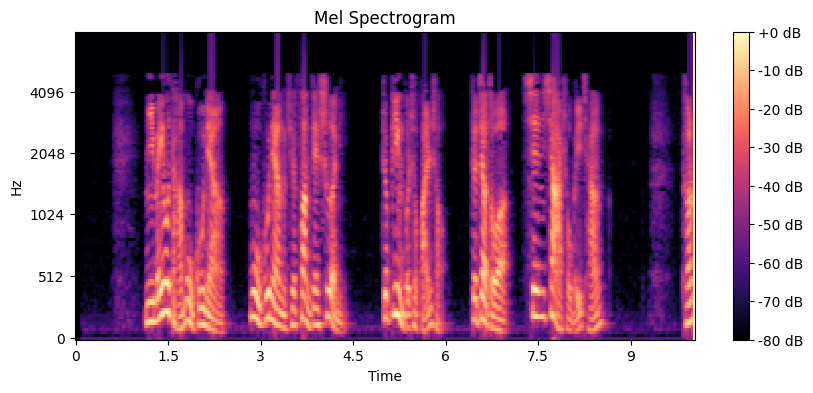

In [7]:
def generate_mel_spectrogram(file_path, target_length=314):
    """Generate a Mel Spectrogram from an audio file with consistent size"""
    try:
        waveform, sample_rate = torchaudio.load(file_path)

        # Convert to mono if needed
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample to 16kHz if needed
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)
            sample_rate = 16000

        # Generate mel spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=waveform.numpy()[0],
            sr=sample_rate,
            n_mels=128
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Pad or truncate to target length
        if mel_spec_db.shape[1] < target_length:
            pad_width = target_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        elif mel_spec_db.shape[1] > target_length:
            mel_spec_db = mel_spec_db[:, :target_length]

        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Test with a sample file
train_files = find_audio_files("/content/dataset/train/Chinese/")
if train_files:
    file_path = train_files[0]
    print("Processing file:", file_path)

    mel_spec = generate_mel_spectrogram(file_path)
    if mel_spec is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec, sr=16000, x_axis='time', y_axis='mel')
        plt.title("Mel Spectrogram")
        plt.colorbar(format='%+2.0f dB')
        plt.show()
else:
    print("No training files found!")

# **7.  Define Simplified AASIST Mode**

In [8]:
class AASISTSimplified(nn.Module):
    def __init__(self, input_shape=(1, 128, 314)):
        super(AASISTSimplified, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate flattened size after convolutions
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.conv1(dummy_input)
            dummy_output = self.pool1(dummy_output)
            dummy_output = self.conv2(dummy_output)
            dummy_output = self.pool2(dummy_output)
            self.flattened_size = dummy_output.numel() // dummy_output.shape[0]

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 2)  # 2 classes: tampered/untampered

    def forward(self, x):
        # Convolutional layers
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        # Fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AASISTSimplified().to(device)
print(f"Model initialized on {device}")

Model initialized on cpu


# **8.Train the Model**

In [9]:
def train_model(model, train_files, num_epochs=5, batch_size=16):
    optimizer = Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    # Create batches
    def create_batches(files, batch_size):
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            batch_data = []
            batch_labels = []

            for file in batch_files:
                mel_spec = generate_mel_spectrogram(file)
                if mel_spec is not None:
                    batch_data.append(mel_spec)
                    batch_labels.append(1 if "tampered" in file else 0)

            if batch_data:
                yield torch.stack([torch.tensor(d).unsqueeze(0) for d in batch_data]), torch.tensor(batch_labels)

    print("Training started...")
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(create_batches(train_files, batch_size)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 9:  # Print every 10 batches
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}: Loss = {running_loss/(batch_idx+1):.4f}, Accuracy = {100*correct/total:.2f}%")

        epoch_loss = running_loss / len(train_files)
        epoch_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

    print("Training complete!")

# Train the model
if train_files:
    train_model(model, train_files)
else:
    print("No training files available!")

Training started...
Epoch 1, Batch 10: Loss = 0.1654, Accuracy = 90.00%
Epoch 1, Batch 20: Loss = 0.0827, Accuracy = 95.00%
Epoch 1, Batch 30: Loss = 0.0551, Accuracy = 96.67%
Epoch 1, Batch 40: Loss = 0.0413, Accuracy = 97.50%
Epoch 1, Batch 50: Loss = 0.0331, Accuracy = 98.00%
Epoch 1, Batch 60: Loss = 0.0276, Accuracy = 98.33%
Epoch 1, Batch 70: Loss = 0.0236, Accuracy = 98.57%
Epoch 1/5: Loss = 0.0014, Accuracy = 98.63%
Epoch 2, Batch 10: Loss = 0.0000, Accuracy = 100.00%
Epoch 2, Batch 20: Loss = 0.0000, Accuracy = 100.00%
Epoch 2, Batch 30: Loss = 0.0000, Accuracy = 100.00%
Epoch 2, Batch 40: Loss = 0.0000, Accuracy = 100.00%
Epoch 2, Batch 50: Loss = 0.0000, Accuracy = 100.00%
Epoch 2, Batch 60: Loss = 0.0000, Accuracy = 100.00%
Epoch 2, Batch 70: Loss = 0.0000, Accuracy = 100.00%
Epoch 2/5: Loss = 0.0000, Accuracy = 100.00%
Epoch 3, Batch 10: Loss = 0.0000, Accuracy = 100.00%
Epoch 3, Batch 20: Loss = 0.0000, Accuracy = 100.00%
Epoch 3, Batch 30: Loss = 0.0000, Accuracy = 100.0

# **9. Evaluting and Visualising the Model**

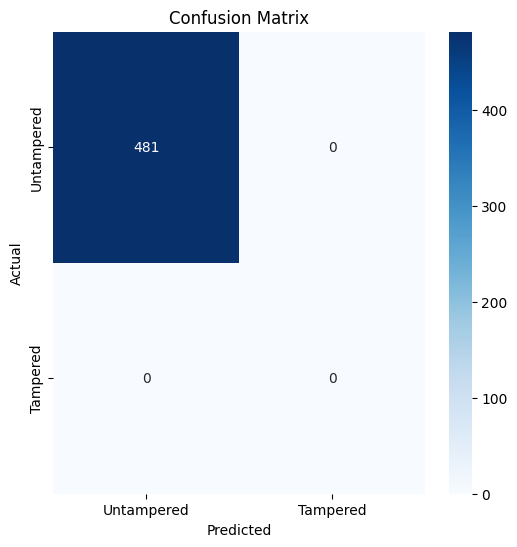

In [22]:

def classification(model, test_files, batch_size=16):
    """
    Evaluate the model's performance on the test dataset.
    Args:
        model: Trained PyTorch model.
        test_files: List of paths to test audio files.
        batch_size: Number of files to process in a batch.
    """
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    def create_batches(files, batch_size):
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            batch_data = []
            batch_labels = []

            for file in batch_files:
                mel_spec = generate_mel_spectrogram(file)
                if mel_spec is not None:
                    batch_data.append(mel_spec)
                    batch_labels.append(1 if "tampered" in file else 0)

            if batch_data:
                yield torch.stack([torch.tensor(d).unsqueeze(0) for d in batch_data]), torch.tensor(batch_labels)

    with torch.no_grad():
        for inputs, labels in create_batches(test_files, batch_size):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted labels

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])  # Include both classes
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Untampered", "Tampered"], yticklabels=["Untampered", "Tampered"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Test the model with the test files
test_files = find_audio_files("/content/dataset/test/Chinese/")
if test_files:
    classification(model, test_files)  # Call the renamed function
else:
    print("No test files available!")

# **10. Training and its reult**

Training started...
Epoch 1/5: Loss = 0.0000, Accuracy = 100.00%
Epoch 2/5: Loss = 0.0000, Accuracy = 100.00%
Epoch 3/5: Loss = 0.0000, Accuracy = 100.00%
Epoch 4/5: Loss = 0.0000, Accuracy = 100.00%
Epoch 5/5: Loss = 0.0000, Accuracy = 100.00%
Training complete!


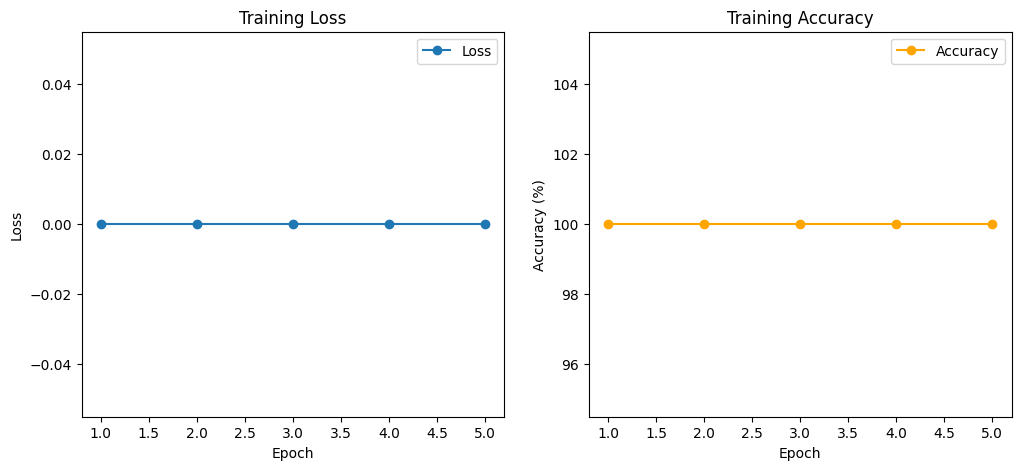

In [11]:
def train_model(model, train_files, num_epochs=5, batch_size=16):
    optimizer = Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    # Initialize lists to store training progress
    epoch_losses = []
    epoch_accuracies = []

    def create_batches(files, batch_size):
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            batch_data = []
            batch_labels = []

            for file in batch_files:
                mel_spec = generate_mel_spectrogram(file)
                if mel_spec is not None:
                    batch_data.append(mel_spec)
                    batch_labels.append(1 if "tampered" in file else 0)

            if batch_data:
                yield torch.stack([torch.tensor(d).unsqueeze(0) for d in batch_data]), torch.tensor(batch_labels)

    print("Training started...")
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in create_batches(train_files, batch_size):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / len(train_files)
        epoch_acc = 100 * correct / total
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

    print("Training complete!")

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), epoch_losses, marker="o", label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), epoch_accuracies, marker="o", color="orange", label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training Accuracy")
    plt.legend()

    plt.show()

# Train the model
if train_files:
    train_model(model, train_files)
else:
    print("No training files available!")